In [1]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

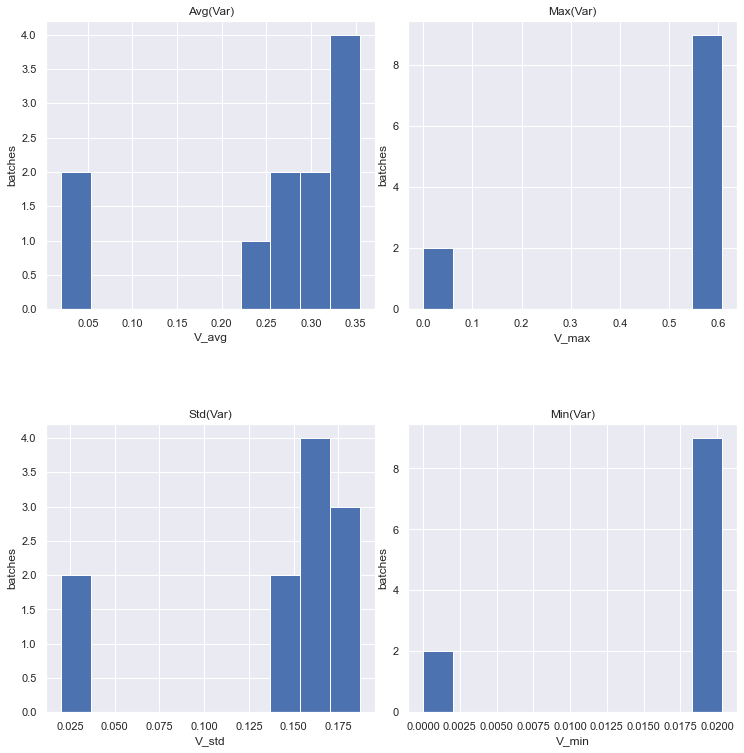

In [157]:
def plot_V_info(V_info):
    """[summary]

    Args:
        V_info ([type]): [description]
    """
    global fig, ax
    figscale, defaultSize = 2, np.array([8, 6])
    fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=figscale*defaultSize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4, left = 0.1, right = 0.7, bottom = 0.1, top = 0.9) 
    
    ax[0,0].hist(V_info["avg"])
    ax[0,0].set(xlabel="V_avg", ylabel="batches", title="Avg(Var)")
    
    ax[1,0].hist(V_info["std"])
    ax[1,0].set(xlabel="V_std", ylabel="batches", title="Std(Var)")

    ax[0,1].hist(V_info["max"])
    ax[0,1].set(xlabel="V_max", ylabel="batches", title="Max(Var)")

    ax[1,1].hist(V_info["min"])
    ax[1,1].set(xlabel="V_min", ylabel="batches", title="Min(Var)")

    plt.show()

plot_V_info(V_info)

In [264]:
import time
from IPython.display import clear_output

start_time = time.time()


def main():
    # There are about 220,000 features, so we can loop <= 110 times.
    csvBatchSize = 2001
    maxIteration = 10

    V_info = {}
    V_info["avg"] = np.empty(maxIteration + 1) 
    V_info["std"] = np.empty(maxIteration + 1) 
    V_info["max"] = np.empty(maxIteration + 1) 
    V_info["min"] = np.empty(maxIteration + 1) 

    for csvBatch_idx, csvBatch in enumerate(pd.read_csv("gtTypes.csv", chunksize=csvBatchSize)):
        data = csvBatch
        # current_time = time.time() - start_time
        # print(f"{current_time:.2f}")
        X = data.values[:, 1:].astype(float).T

        varAnalysisInfo = varAnalysis(X=X)
        V_info["avg"][csvBatch_idx], V_info["std"][csvBatch_idx] = varAnalysisInfo[:2]
        V_info["max"][csvBatch_idx], V_info["min"][csvBatch_idx] = varAnalysisInfo[2:]
        
        # Dynamically plot variance distributions
        V_info_sofar = {} 
        for key in V_info:
            V_info_sofar[key] = V_info[key][:csvBatch_idx + 1]
        clear_output(wait=True)
        print(f"----------\ncsvBatch: {csvBatch_idx}")
        plot_V_info(V_info_sofar)
        
        
        if csvBatch_idx == maxIteration:
            break
            
    return V_info

In [266]:
V_info

{'avg': array([0.35519811, 0.27620382, 0.27065254, 0.33960878, 0.2455199 ,
        0.29156451, 0.34121771, 0.31030169, 0.34225726, 0.02      ,
        0.0225    ]),
 'std': array([0.18720089, 0.14902071, 0.17080823, 0.15825318, 0.16967155,
        0.14056323, 0.16085496, 0.16920851, 0.17139048, 0.02      ,
        0.0225    ]),
 'max': array([ 5.97766696e-01,  5.93741636e-01,  5.92234566e-01,  5.96526954e-01,
         5.74072402e-01,  5.87356394e-01,  6.09020010e-01,  5.95824706e-01,
         5.86969764e-01,  0.00000000e+00, -5.00000000e-04]),
 'min': array([1.98156798e-002, 2.03544376e-002, 1.98156798e-002, 1.98156798e-002,
        1.98156798e-002, 1.98156798e-002, 1.98156798e-002, 1.98156798e-002,
        1.98156798e-002, 0.00000000e+000, 1.08646185e-311])}

----------
csvBatch: 10


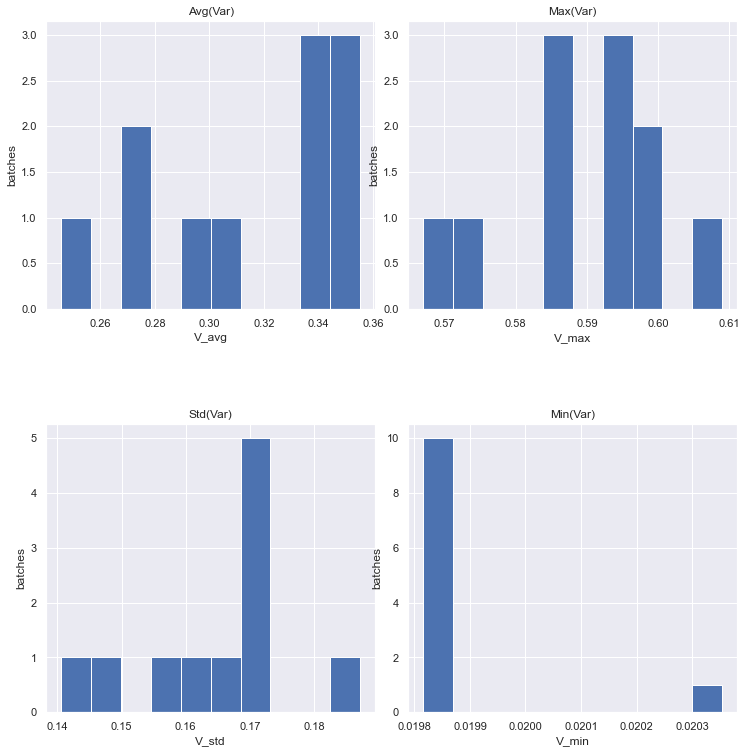

In [265]:
if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("stopped")

In [204]:
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

In [249]:

X = data.values[:, 1:].astype(float).T

rng = np.random.RandomState(7)
Y = rng.randint(0,2, X.shape[0]).reshape(-1,1)

items, coefs, ps = [], [], []
try:
    for row in X.T:
        x = row.reshape(-1, 1)
        model = SGDClassifier(loss='log')
        model.fit(x, Y)
        y_pred = model.predict(x)
        items.append(y_pred)
        coefs.append(model.coef_[0,0])
        sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
        ps.append(sm_model.pvalues[1])
        
except KeyboardInterrupt:
    print("stopped")

stopped


In [267]:
# compare with statsmodels
import statsmodels.api as sm
# print(sm.add_constant(x))

print(pd.Series(sm.add_constant(x)[:, 1]).value_counts())

sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues[1])

2.0    798
1.0    746
0.0    236
dtype: int64
0.3191284072206093


0.8865296258896433

- Jie Yuan1:26 PM https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- Jie Yuan1:30 PM https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
- McKelvey & Zavoina https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

0.09355327625915083

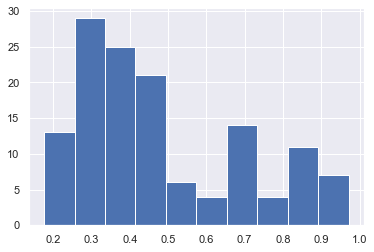

In [256]:
ps = np.abs(ps)
plt.hist(ps);
np.percentile(np.abs(coefs), 25)

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>]], dtype=object)

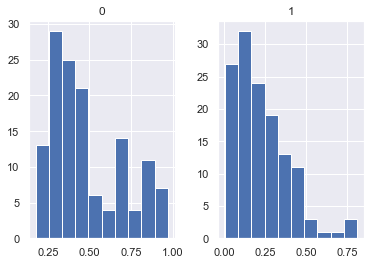

In [263]:
df = pd.DataFrame([ps, coefs]).T
df.hist()

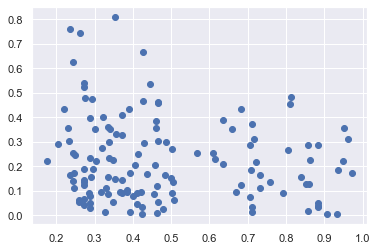

In [259]:
plt.scatter(ps, coefs)

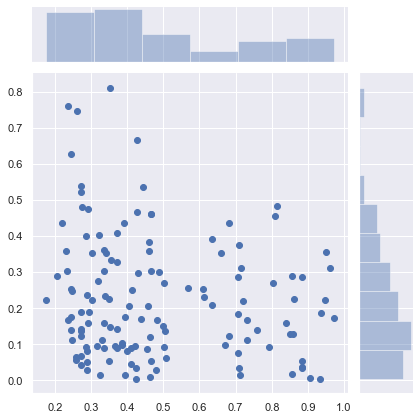

In [258]:
import seaborn as sns; sns.set()

sns.jointplot(ps, coefs, kind="scatter")

0.09355327625915083

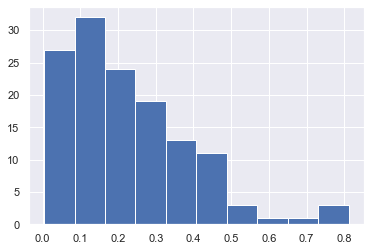

In [257]:
coefs = np.abs(coefs)
plt.hist(coefs);
np.percentile(np.abs(coefs), 25)

In [120]:
def varAnalysis(X, verbose=False):
    V = np.var(X, axis=0)
    V_avg, V_std = np.mean(V), np.std(V)
    V_max, V_min = np.max(V), np.min(V)
    
    if verbose == True:
        print(f"V_avg: {np.mean(V):.3f}")    
        print(f"V_std: {np.std(V):.3f}")
        print(f"V_max: {np.max(V):.3f}")
        print(f"V_min: {np.min(V):.3f}")
    
    return V_avg, V_std, V_max, V_min

varAnalysis(X=X)

(0.35539805151079323,
 0.16860684805289833,
 0.5670278373942512,
 0.019815679838404848)

In [85]:
for col_idx in range(X.shape[1]):
    col = X[:, col_idx] 
    print(f"col var: {np.var(col):.4f}")
    col_counts = dict(pd.Series(col).value_counts())
    print(f"col counts: {col_counts}\n")

col var: 0.0900
col counts: {0.0: 1602, 1.0: 178}

col var: 0.0900
col counts: {0.0: 1602, 1.0: 178}

col var: 0.0900
col counts: {0.0: 1602, 1.0: 178}

col var: 0.0315
col counts: {0.0: 1722, 1.0: 58}

col var: 0.0624
col counts: {0.0: 1661, 1.0: 119}

col var: 0.0767
col counts: {0.0: 1631, 1.0: 149}

col var: 0.0624
col counts: {0.0: 1661, 1.0: 119}

col var: 0.0677
col counts: {0.0: 1650, 1.0: 130}

col var: 0.0629
col counts: {0.0: 1660, 1.0: 120}

col var: 0.0767
col counts: {0.0: 1631, 1.0: 149}

col var: 0.0465
col counts: {0.0: 1693, 1.0: 87}

col var: 0.0465
col counts: {0.0: 1693, 1.0: 87}

col var: 0.0446
col counts: {0.0: 1700, 1.0: 79, 2.0: 1}

col var: 0.0353
col counts: {0.0: 1718, 1.0: 61, 2.0: 1}

col var: 0.1507
col counts: {0.0: 1455, 1.0: 324, 2.0: 1}

col var: 0.2089
col counts: {0.0: 1274, 1.0: 502, 2.0: 4}

col var: 0.0456
col counts: {0.0: 1698, 1.0: 81, 2.0: 1}

col var: 0.0342
col counts: {0.0: 1720, 1.0: 59, 2.0: 1}

col var: 0.0433
col counts: {0.0: 1731, 1